## All drugs training

In [52]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error
from sklearn.externals import joblib

import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

_FOLDER = "results/"
_FOLDER_2= "data/"

from training import *

In [34]:
folders =[x for x in os.listdir(_FOLDER_2) if x.startswith("filt_")]+["no_filt"]
folders

['filt_1234_04', 'filt_123_04_r2_09', 'filt_123_04', 'filt_auc_02', 'no_filt']

### Reading the data

In [35]:
with open(_FOLDER+"X_features_cancer_cell_lines.txt", 'r') as f:
    X_cancer_cell_lines = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_PubChem_properties.txt", 'r') as f:
    X_PubChem_properties = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_features_Targets.txt", 'r') as f:
    X_targets = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER+"X_features_Target_Pathway.txt", 'r') as f:
    X_target_pathway = [line.rstrip('\n') for line in f]
# *****************************************

all_columns = X_cancer_cell_lines + X_PubChem_properties + X_targets + X_target_pathway +["MAX_CONC"]

conc_columns= ["fd_num_"+str(i) for i in range(10)]
response_norm = ['norm_cells_'+str(i) for i in range(10)]

In [36]:
## golden test for comparison

load_golden_test = True

if load_golden_test:
    test_small = pd.read_csv(_FOLDER_2+"train_small_r2_09.csv")
    test_small2 = pd.read_csv(_FOLDER_2+"train_small_r2_099.csv")
    print(test_small.shape, test_small2.shape)
    
else: 
    _FOLDER_3= _FOLDER_2+"filt_123_04/"
    test = pd.read_csv(_FOLDER_3+ "test.csv")
    test_small = test[test["sigmoid_4_param_r2"]>0.9]
    test_small.to_csv(_FOLDER_2+"train_small_r2_09.csv", index=False)

    test_small2 = test[test["sigmoid_4_param_r2"]>0.99]
    test_small2.to_csv(_FOLDER_2+"train_small_r2_099.csv", index=False)
    print(test.shape, test_small.shape[0], test_small2.shape[0]) #(460), 449, 319

(449, 1396) (319, 1396)


In [37]:
test_small

,DRUGID_COSMICID,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,FOLD_DILUTION,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,fd_num_3,...,chr9:104248247-104249501(C9orf125)_HypMET,"chr9:115875199-115875738(C9orf109, C9orf110)_HypMET",chr9:123555399-123555899(FBXW2)_HypMET,chr9:140310894-140312457(EXD3)_HypMET,chr9:21974578-21975306(CDKN2A)_HypMET,chr9:35756948-35757339(MSMP)_HypMET,chr9:35791584-35791924(NPR2)_HypMET,chr9:4984543-4985630(JAK2)_HypMET,chr9:86571047-86572027(C9orf64)_HypMET,chr9:98783216-98784364(NCRNA00092)_HypMET
0,11_909720,SK-LMS-1,909720,11,2,0.1024,0,0.111111,0.222222,0.333333,...,0,0,0,0,0,0,0,0,0,0
1,11_907073,HUTU-80,907073,11,2,0.1024,0,0.111111,0.222222,0.333333,...,0,0,0,0,0,0,0,0,0,0
2,11_907170,IMR-5,907170,11,2,0.1024,0,0.111111,0.222222,0.333333,...,0,0,0,0,0,0,0,0,0,0
3,11_1299075,VCaP,1299075,11,2,0.1024,0,0.111111,0.222222,0.333333,...,0,0,0,0,0,0,0,0,0,0
4,41_1331034,SU-DHL-16,1331034,41,2,5.1200,0,0.111111,0.222222,0.333333,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,1149_687985,DMS-273,687985,1149,2,5.0000,0,0.111111,0.222222,0.333333,...,0,0,0,0,0,0,0,0,0,0
445,1149_1240172,MDA-MB-436,1240172,1149,2,5.0000,0,0.111111,0.222222,0.333333,...,0,0,0,0,0,0,0,0,0,0
446,1149_1240221,TC-71,1240221,1149,2,5.0000,0,0.111111,0.222222,0.333333,...,0,0,0,0,0,0,0,0,0,0
447,1149_1240179,MS751,1240179,1149,2,5.0000,0,0.111111,0.222222,0.333333,...,0,0,0,0,0,0,0,0,0,0


In [25]:
os.listdir(_FOLDER_3)

['test2.csv', 'test.csv', 'train.csv', 'test_gdsc2.csv']

In [12]:
parameters_rfe = {
    1: { "kernel" : "linear", 
        "C": 0.01,
        "epsilon" : 0.1
        },
    2: { "kernel" : "linear", 
        "C": 0.01,
        "epsilon" : 0.001
        },
    
    3: { "kernel" : "linear", 
        "C": 0.1,
        "epsilon" : 1
        },
    4: { "kernel" : "linear", 
        "C": 0.01,
        "epsilon" : 0.01
        }
}

In [13]:
parameters_model = {
    1: { "kernel" : "rbf", 
        "C" : 0.5,
        "epsilon" : 0.01,
        "coef0" : 0.01
        },
    2: { "kernel" : "rbf", 
        "C": 0.1,
        "epsilon" : 0.01,
        "coef0" : 0.01
        },
    3: { "kernel" : "rbf", 
        "C": 5,
        "epsilon" : 1,
        "coef0" : 0.01
        },
    4: { "kernel" : "rbf", 
        "C": 0.1,
        "epsilon" : 0.001,
        "coef0" : 0.01
        }
}

## Coefficient 1

In [47]:
%%time
filteting = "filt_123_04"
_FOLDER_3= _FOLDER_2 + filteting + "/"

train = pd.read_csv(_FOLDER_3+ "train.csv")
test = pd.read_csv(_FOLDER_3+ "test.csv")
test2 = pd.read_csv(_FOLDER_3+ "test2.csv")
print(train.shape, test.shape, test2.shape)

model, scaler = Train_SVR_all(train, X_columns = all_columns, coefficient=1, 
                              **parameters_model[1])

TestSVRCoef_all_drugs(test, all_columns, model, scaler, coefficient=1, training_details= filteting+ "/test")
TestSVRCoef_all_drugs(test2, all_columns, model, scaler, coefficient=1, training_details= filteting+ "/test2")
TestSVRCoef_all_drugs(test_small, all_columns, model, scaler, coefficient=1, training_details= filteting+ "/test_r2>0.9")
TestSVRCoef_all_drugs(test_small2, all_columns, model, scaler, coefficient=1, training_details=filteting+ "/test_r2>0.99")

(1721, 1396) (460, 1396) (242, 1396)

Coefficient 1, Modelling for filt_123_04/test

MAE: 0.184 +/- 0.458
MRE: 26.1 +/- 27.7

Coefficient 1, Modelling for filt_123_04/test2

MAE: 0.436 +/- 2.041
MRE: 19.9 +/- 52.2

Coefficient 1, Modelling for filt_123_04/test_r2>0.9

MAE: 0.120 +/- 0.131
MRE: 25.1 +/- 24.4

Coefficient 1, Modelling for filt_123_04/test_r2>0.99

MAE: 0.101 +/- 0.102
MRE: 20.2 +/- 26.1
CPU times: user 6.4 s, sys: 0 ns, total: 6.4 s
Wall time: 6.4 s


filt_123_04/test r2>0.9 (449, 1402)


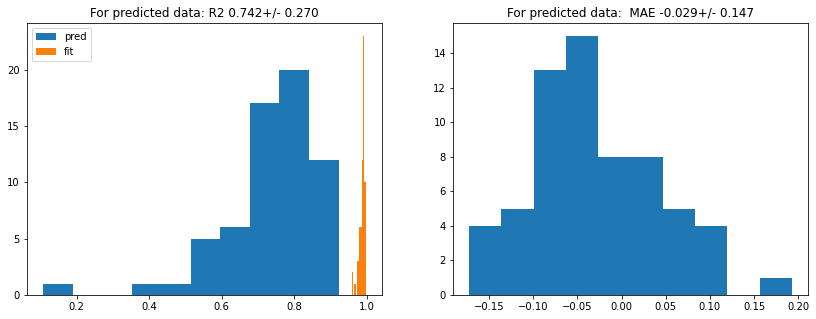

In [48]:
training_details = filteting +"/test"    
df = test_small
test_pred =  ReconstructSVR_all_drugs(df, all_columns, "sigmoid_4_param", 
                                      conc_columns, response_norm, n_coef = 4, 
                                      recompute_predictions = False,
                                      #model_dict=None, scaler_dict=None, 
                                      training_details=training_details, drop_columns=True)
print(training_details, "r2>0.9", test_pred.shape)
#statistics by drug
gr = test_pred.groupby("DRUG_ID")[["sigmoid_4_param_r2","pred_fit_r2", "mae_pred"]].mean()
gr

fig = plt.figure(figsize=(14, 5))
fig.subplots_adjust(hspace=0.4)

ax = fig.add_subplot(121) #fig.add_subplot(ROW,COLUMN,POSITION)
ax.hist(gr["pred_fit_r2"], label= "pred")
ax.hist(gr["sigmoid_4_param_r2"], label= "fit")
ax.legend()

ax.set_title("For predicted data: R2 %0.3f+/- %0.3f" % (gr["pred_fit_r2"].mean(), 2*gr["pred_fit_r2"].std()))

ax = fig.add_subplot(122)
ax.hist(gr["mae_pred"])
ax.set_title("For predicted data:  MAE %0.3f+/- %0.3f" % (gr["mae_pred"].mean(), 2*gr["mae_pred"].std()));


filt_123_04/test r2>0.99 (319, 1402)


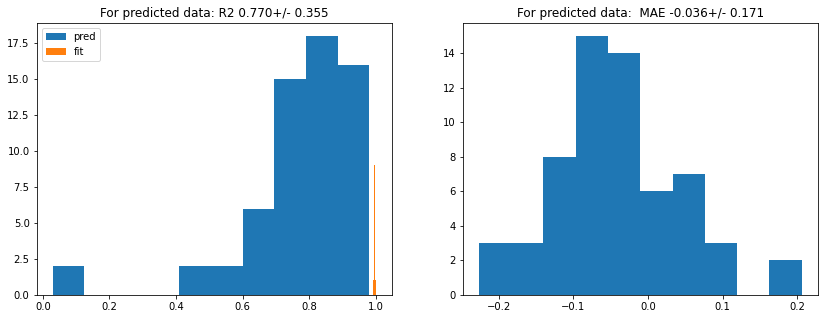

In [49]:
training_details = filteting +"/test"    
df = test_small2
test_pred =  ReconstructSVR_all_drugs(df, all_columns, "sigmoid_4_param", 
                                      conc_columns, response_norm, n_coef = 4, 
                                      recompute_predictions = False,
                                      #model_dict=None, scaler_dict=None, 
                                      training_details=training_details, drop_columns=True)
print(training_details, "r2>0.99", test_pred.shape)
#statistics by drug
gr = test_pred.groupby("DRUG_ID")[["sigmoid_4_param_r2","pred_fit_r2", "mae_pred"]].mean()
gr

fig = plt.figure(figsize=(14, 5))
fig.subplots_adjust(hspace=0.4)

ax = fig.add_subplot(121) #fig.add_subplot(ROW,COLUMN,POSITION)
ax.hist(gr["pred_fit_r2"], label= "pred")
ax.hist(gr["sigmoid_4_param_r2"], label= "fit")
ax.legend()

ax.set_title("For predicted data: R2 %0.3f+/- %0.3f" % (gr["pred_fit_r2"].mean(), 2*gr["pred_fit_r2"].std()))

ax = fig.add_subplot(122)
ax.hist(gr["mae_pred"])
ax.set_title("For predicted data:  MAE %0.3f+/- %0.3f" % (gr["mae_pred"].mean(), 2*gr["mae_pred"].std()));

## No filtering only fitting

In [17]:
%%time

filteting = "no_filt"
_FOLDER_3= _FOLDER_2 + filteting + "/"

train = pd.read_csv(_FOLDER_3+ "train.csv")
test = pd.read_csv(_FOLDER_3+ "test.csv")
test2 = pd.read_csv(_FOLDER_3+ "test2.csv")
print(train.shape, test.shape, test2.shape)


model_dict = {}
scaler_dict = {}

for i in range(1,5):
    print("\nComputing model for coefficent ", i)
    
    model, scaler = Train_SVR_all(train, X_columns = all_columns, coefficient=i, 
                              **parameters_model[i])
    model_dict[i] = model
    scaler_dict[i] = scaler

    TestSVRCoef_all_drugs(test, all_columns, model, scaler, coefficient=i, training_details= filteting+ "/test")
    TestSVRCoef_all_drugs(test2, all_columns, model, scaler, coefficient=i, training_details= filteting+ "/test2")
    TestSVRCoef_all_drugs(test_small, all_columns, model, scaler, coefficient=i, training_details= filteting+ "/test_r2>0.9")
    TestSVRCoef_all_drugs(test_small2, all_columns, model, scaler, coefficient=i, training_details=filteting+ "/test_r2>0.99")
    
    joblib.dump(scaler, _FOLDER_2+ "scaler_" + str(i) + ".sav")
    joblib.dump(model, _FOLDER_3+ "SVR_" + str(i) + ".sav")
    

(37782, 1394) (9546, 1394) (60, 1394)

Computing model for coefficent  1

Coefficient 1, Modelling for no_filt/test

MAE: 0.215 +/- 0.228
MRE: 35.2 +/- 239.7

Coefficient 1, Modelling for no_filt/test2

MAE: 0.281 +/- 0.308
MRE: 5.2 +/- 427.3

Coefficient 1, Modelling for no_filt/test_r2>0.9

MAE: 0.115 +/- 0.112
MRE: 26.9 +/- 29.4

Coefficient 1, Modelling for no_filt/test_r2>0.99

MAE: 0.101 +/- 0.092
MRE: 22.6 +/- 30.5

Computing model for coefficent  2

Coefficient 2, Modelling for no_filt/test

MAE: 1.070 +/- 2.024
MRE: 53.4 +/- 108.4

Coefficient 2, Modelling for no_filt/test2

MAE: 4.084 +/- 3.317
MRE: 43.2 +/- 78.3

Coefficient 2, Modelling for no_filt/test_r2>0.9

MAE: 0.145 +/- 0.142
MRE: 15.6 +/- 26.6

Coefficient 2, Modelling for no_filt/test_r2>0.99

MAE: 0.111 +/- 0.124
MRE: 9.2 +/- 12.4

Computing model for coefficent  3

Coefficient 3, Modelling for no_filt/test

MAE: 24.965 +/- 44.635
MRE: -71.1 +/- 150.3

Coefficient 3, Modelling for no_filt/test2

MAE: 52.282 +/- 63.

In [38]:
filteting = "no_filt"
_FOLDER_3= _FOLDER_2 + filteting + "/"
model_dict = {}
scaler_dict = {}

for i in range(1,5):
    model_dict[i]= joblib.load(_FOLDER_3+ "SVR_" + str(i) + ".sav")
    scaler_dict[i]= joblib.load(_FOLDER_2+ "scaler_" + str(i) + ".sav")

no_filt/test r2>0.9 (449, 1402)


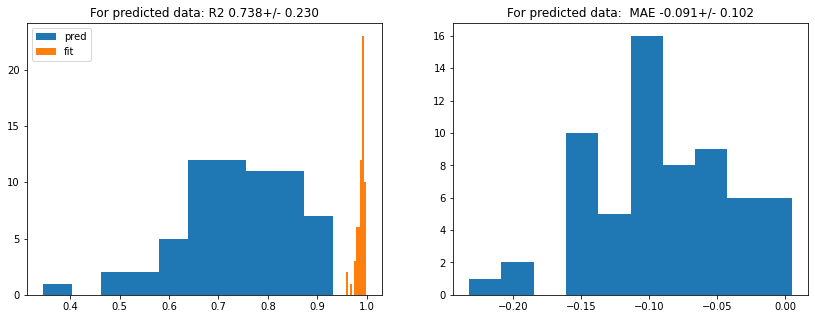

In [42]:
training_details = filteting +"/test"    
df = test_small
test_pred =  ReconstructSVR_all_drugs(df, all_columns, "sigmoid_4_param", 
                                      conc_columns, response_norm, n_coef = 4, 
                                      recompute_predictions = True,
                                      model_dict=model_dict, scaler_dict=scaler_dict, 
                                      training_details=training_details, drop_columns=True)
print(training_details, "r2>0.9", test_pred.shape)
#statistics by drug
gr = test_pred.groupby("DRUG_ID")[["sigmoid_4_param_r2","pred_fit_r2", "mae_pred"]].mean()
gr

fig = plt.figure(figsize=(14, 5))
fig.subplots_adjust(hspace=0.4)

ax = fig.add_subplot(121) #fig.add_subplot(ROW,COLUMN,POSITION)
ax.hist(gr["pred_fit_r2"], label= "pred")
ax.hist(gr["sigmoid_4_param_r2"], label= "fit")
ax.legend()

ax.set_title("For predicted data: R2 %0.3f+/- %0.3f" % (gr["pred_fit_r2"].mean(), 2*gr["pred_fit_r2"].std()))

ax = fig.add_subplot(122)
ax.hist(gr["mae_pred"])
ax.set_title("For predicted data:  MAE %0.3f+/- %0.3f" % (gr["mae_pred"].mean(), 2*gr["mae_pred"].std()));


no_filt/test r2>0.99 (319, 1402)
CPU times: user 50 s, sys: 4 ms, total: 50 s
Wall time: 50 s


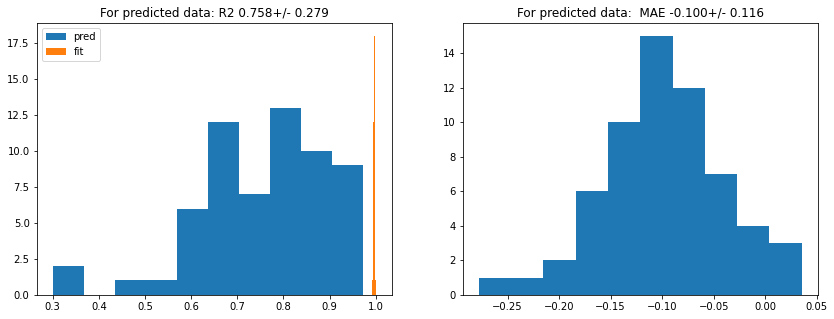

In [43]:
%%time
training_details = filteting +"/test"    
df = test_small2
test_pred =  ReconstructSVR_all_drugs(df, all_columns, "sigmoid_4_param", 
                                      conc_columns, response_norm, n_coef = 4, 
                                      recompute_predictions = True,
                                      model_dict=model_dict, scaler_dict=scaler_dict, 
                                      training_details=training_details, drop_columns=True)
print(training_details, "r2>0.99", test_pred.shape)
#statistics by drug
gr = test_pred.groupby("DRUG_ID")[["sigmoid_4_param_r2","pred_fit_r2", "mae_pred"]].mean()
gr

fig = plt.figure(figsize=(14, 5))
fig.subplots_adjust(hspace=0.4)

ax = fig.add_subplot(121) #fig.add_subplot(ROW,COLUMN,POSITION)
ax.hist(gr["pred_fit_r2"], label= "pred")
ax.hist(gr["sigmoid_4_param_r2"], label= "fit")
ax.legend()

ax.set_title("For predicted data: R2 %0.3f+/- %0.3f" % (gr["pred_fit_r2"].mean(), 2*gr["pred_fit_r2"].std()))

ax = fig.add_subplot(122)
ax.hist(gr["mae_pred"])
ax.set_title("For predicted data:  MAE %0.3f+/- %0.3f" % (gr["mae_pred"].mean(), 2*gr["mae_pred"].std()));
